In [1]:
# Imports
import numpy as np
import math
import matplotlib.pyplot as plt
from __future__ import division
np.random.seed(1)

### Q.1 (70pts) Define functions

In [2]:
# One hot encode the labels
def one_hot_encode(y):
    targets = np.array(np.unique(y)).reshape(-1)
    enc = np.eye(len(targets))[y]
    print(enc)
    return enc

# Get the loss of for the training example
def cross_entropy(Y, Yhat):
    m= Y.shape[1]
    eps=1e-15
    Yhat = np.clip(Yhat, eps, 1-eps)
    loss = np.multiply(np.log(Yhat),Y) + np.multiply((1.-Y), np.log(1. - Yhat))
    loss = np.sum(loss)
    cost = -1./m * np.sum(loss)
    cost = np.squeeze(cost)
    return cost

# Applying Sigmoid Activation function to the hidden layer outputs used while forward propagation
# Purpose of this method is to do squishing on the linear function
def sigmoid(z):
    print("Before sigmoid---")
    print(z)
    sigmoid = 1 / (1 + np.exp(-z))
    print("After sigmoid---")
    print(sigmoid)
    return sigmoid

# Applying Sigmoid Activation function to the hidden layer outputs used while backward propagation to get gradients
# Purpose of this method is to do undo the squishing on the linear function
def sigmoid_prime(z):
    inv = (np.exp(-z))/(np.power((1+np.exp(-z)),2))
    return inv

def relu(z):
    return np.maximum(z,0)
    
def relu_prime(z):
    return np.where(z < 0, 0.0, 1.0)

# Softmax activation function to get the probablity of the classes
def softmax(z):
    softMax = (np.exp(z) / np.sum(np.exp(z),axis=0))
    softMax = np.matrix(np.argmax(softMax,axis=0)).T
    return softMax

def zero_pad(X, pad):
    ## Pads the height and width and breadth only by 'pad' columns using constant value, 4 dimensional padding
    padded_array = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0,0)), 'constant', constant_values = (0,0))
    print("Dimension after padding" + str(padded_array.shape))
    return padded_array

# Convolution of a slice
def convolute_slice(a_slice, W, b):
    conv = np.multiply(a_slice, W)
    z = np.sum(conv) + float(b)
    return z

# Calculate the coordinates of the slice
def get_slice_coordinates(stride, f, w, h):
    vert_start = h * stride
    vert_end = vert_start + f
    horiz_start = w * stride
    horiz_end = horiz_start + f
    return vert_start, vert_end, horiz_start, horiz_end

# Flatten the array
def flatten(A):
    (m, nH, nW, nC) = A.shape
    print('Shape before flattening is----')
    print(A.shape)
    A = A.reshape(m, nH * nW * nC)
    print('Shape after flattening is----')
    print(A.shape)
    return A.transpose()

def convolute_forward(A_prev, W, b, hyper_params):
    # Get the required parameters
    m, nH_prev, nW_prev, nC_prev = A_prev.shape
    f, f, nC_prev, nC  = W.shape
    pad = hyper_params["pad"]
    stride = hyper_params["stride"]
    print('convolution nH_prev, f, pad, stride---------------')
    print(nH_prev, f, pad, stride)
    # Calculate the dimensions of input
    nH = int((nH_prev -f + 2 * pad)/stride) + 1
    nW = int((nW_prev -f + 2 * pad)/stride) + 1
    print('convolution m, nH, nW, nC---------------')
    print(m, nH, nW, nC)
    # Calculate the dimensions of output
    Z = np.zeros((m, nH, nW, nC))
    A_prev_pad = zero_pad(A_prev, pad)
    
    # referring professor's code for forward propagation
    for i in range(m):
        a_pad_prev = A_prev_pad[i, :, :, :]
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):
                    # Find the coordinates of the current slice
                    vert_start, vert_end, horiz_start, horiz_end = get_slice_coordinates(stride, f, w, h)
                    
                    # Extract the slice from input
                    a_slice_prev = a_pad_prev[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron
                    Z[i, h, w, c] = convolute_slice(a_slice_prev, W[:, :, :, c], b[:, :, :, c])
                    
    cache = (A_prev, W, b, hyper_params)
    return Z

def pool_forward(A_prev, hyper_params, pooling_method):
    # Get the required parameters
    (m, nH_prev, nW_prev, nC_prev) = A_prev.shape
    print('Pooling (m, nH_prev, nW_prev, nC_prev---------------')
    print(m, nH_prev, nW_prev, nC_prev)
    f = hyper_params["f"]
    stride = hyper_params["stride"]
    print('Pooling f, stride')
    print(f, stride)
    # Calculate the dimensions of the output
    nH = int(1 + (nH_prev - f) / stride)
    nW = int(1 + (nW_prev - f) / stride)
    nC = nC_prev
    #print(nH, nW, nC)
    # Initialize the output matrix
    A = np.zeros((m, nH, nW, nC))
    
    for i in range(m):
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):
                    
                    # Find the coordinates of the current slice
                    vert_start, vert_end, horiz_start, horiz_end = get_slice_coordinates(stride, f, w, h)
                    
                     # Extract the slice from input
                    a_slice_prev = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Perform the pooling on the slice
                    if(pooling_method == "max"):
                        A[i, h, w, c] = np.max(a_slice_prev)
                    elif(pooling_method == "avg"):
                        A[i, h, w, c] = np.mean(a_slice_prev)
    cache = (A_prev, hyper_params)                
    assert(A.shape == (m, nH, nW, nC))
    return A
        
             
def convolute_backward(dZ, A_prev, W, b, hyper_params):
    # Get the input dimensions
    (m, nH_prev, nW_prev, nC_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape
    stride = hyper_params["stride"]
    pad = hyper_params["pad"]
    (m, nH, nW, nC) = dZ.shape
    dA_prev = np.zeros((m, nH_prev, nW_prev, nC_prev))                           
    dW = np.zeros((f, f, nC_prev, nC))
    db = np.zeros((1, 1, 1, n_C))
    A_pad_prev = zero_pad(A_prev, pad)
    dA_pad_prev = zero_pad(dA_prev, pad)
    
    for i in range(m):
        
        a_pad_prev = A_pad_prev[i,:,:,:]
        da_pad_prev = dA_pad_prev[i,:,:,:]
        
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):

                    # Find the coordinates of the current slice
                    vert_start, vert_end, horiz_start, horiz_end = get_slice_coordinates(stride, f, w, h)

                    # Extract the slice from input
                    a_slice = A_pad_prev[i, vert_start:vert_end, horiz_start:horiz_end, :]

                    da_pad_prev[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
    
        #dA_prev[i, :, :, :] = da_pad_prev[pad:-pad, pad:-pad, :]
    assert(dA_prev.shape == (m, nH_prev, nW_prev, nC_prev))
    return dA_prev, dW, db


# Backward pass for max pooling for a slice
def backprop_max_pooling(x):
    mask = x==np.max(x)
    return mask

# Backward pass for avg pooling for a slice
def backprop_avg_pooling(dz, slice_shape):
    (nH, nW) = slice_shape
    avg = dz/(nH * nW) # calculate avg
    a = np.ones((nH, nW)) * avg
    return a


def pool_backward(dA, A_prev, hyper_params, pooling_method):
    stride = hyper_params["stride"]
    f = hyper_params["f"]
    m, nH_prev, nW_prev, nC_prev = A_prev.shape
    m, nH, nW, nC = dA.shape
    dA_prev = np.zeros((m, nH_prev, nW_prev, nC_prev))
    
    for i in range(m):
        a_prev = A_prev[i,:,:,:]
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):
                    
                    # Find the coordinates of the current slice
                    vert_start, vert_end, horiz_start, horiz_end = get_slice_coordinates(stride, f, w, h)
                    #print("coordinate")
                    #print(vert_start, vert_end, horiz_start, horiz_end)
                    if(pooling_method == "max"):
                        a_slice_prev = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]                  
                        mask = backprop_max_pooling(a_slice_prev)
                        temp = mask * dA[i, h, w, c]
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += temp

                    elif(pooling_method == "avg"):
                        da = dA[i, h, w, c]
                        shape = (f,f)
                        #print('-----------dAprev shape---------')
                        #print(dA_prev.shape)
                        #print('-----------temp---------')
                        temp = backprop_avg_pooling(da, shape)
                        #print(temp.shape)
                        #print('--------------dAPrev----------')
                        #print(dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c])
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += temp
    
    assert(dA_prev.shape == A_prev.shape)
    return dA_prev


# Forward propagation to calculate yHat by applying activation function twice
def forward_propagate(cache, hyper_params, parameters):
    
    # Layer 1 Convolution
    cache["Z1c"] = convolute_forward(cache["A0"], parameters["W1c"], parameters["b1c"], hyper_params["c1"]) # Convolution
    cache["A1c"] = relu(cache["Z1c"]) # Relu Activation
#     print('-----------------Z1c--------------')
#     print(cache["Z1c"])
#     print('-----------------A1c--------------')
#     print(cache["A1c"])
    
    # Layer 1 Pooling 
    cache["A1p"] = pool_forward(cache["A1c"], hyper_params["p1"], pooling_method="max") # Pooling
#     print('-----------------A1p--------------')
#     print(cache["A1p"])
    
    # Layer 2 Convolution 
    cache["Z2c"] = convolute_forward(cache["A1p"], parameters["W2c"], parameters["b2c"], hyper_params["c2"]) # Convolution
    cache["A2c"] = relu(cache["Z2c"]) # Relu Activation
#     print('-----------------Z2c--------------')
#     print(cache["Z2c"])
#     print('-----------------A2c--------------')
#     print(cache["A2c"])
    
    # Layer 2 Pooling 
    cache["A2p"] = pool_forward(cache["A2c"],hyper_params["p2"], pooling_method="avg") # Pooling
#     print('-----------------A2p--------------')
#     print(cache["A2p"])
    
    # Flatten the array
    cache["A3"] = flatten(cache["A2p"])
#     print('-----------------A3--------------')
#     print(cache["A3"])

    # Fully Connected Layer 4
    cache["Z4"] = np.dot(parameters["W4"], cache["A3"]) + parameters["b4"]
    cache["A4"] = relu(cache["Z4"]) # Relu Activation 
#     print('-----------------Z4--------------')
#     print(cache["Z4"])
#     print('-----------------A4--------------')
#     print(cache["A4"])
    
    # Fully Connected Layer 5
    cache["Z5"] = np.dot(parameters["W5"], cache["A4"]) + parameters["b5"]
    cache["A5"] = sigmoid(cache["Z5"]) # Sigmoid Activation 
#     print('-----------------Z5--------------')
#     print(cache["Z5"])
#     print('-----------------A5--------------')
#     print(cache["A5"])

    return cache


def backward_propagate(Y, cache, hyper_params, params):
    gradients = {}
    # Fully Connected Layer 5
    m = cache["A5"].shape[1]
    dZ5 = cache["A5"] - Y.transpose()
    dW5 = (1./m) * np.dot(dZ5, cache["A4"].transpose())
    db5 = (1./m) * np.sum(dZ5, axis=1)
    gradients["dW5"] = dW5
    gradients["db5"] = db5
    
    # Fully Connected Layer 4
    temp1 = np.dot( params["W5"].transpose(), dZ5 )
    temp2 = relu_prime(cache["Z4"])
    dZ4 = np.multiply(temp1 , temp2) # element wise product of same dimension matrices
    dW4 = (1./m) * np.dot(dZ4, cache["A3"].transpose())
    db4 = (1./m) * np.sum(dZ4, axis =1)
    gradients["dW4"] = dW4
    gradients["db4"] = db4
    
    # Un-Flaten the list
    (m, nH, nW, nC) = cache["A2p"].shape
    dP2 = cache["A3"].reshape(m, nH, nW, nC)
    
    dA2 = pool_backward(dP2, cache["A2c"], hyper_params["p2"], pooling_method="avg")
    dZ2 = relu_prime(dA2)
    print("shape")
    print(dZ2.shape)
    print(cache["Z2c"].shape)
    dP1, dW2, db2 = convolute_backward(dZ2, cache["A1p"], params["W2c"], params["b2c"], hyper_params["c2"])
    gradients["dW2"] = dW2
    gradients["db2"] = db2
    
    
    dA1 = pool_backward(dP1, cache["A1c"], hyper_params["p1"], pooling_method="max")
    dZ1 = relu_prime(dA1)
    X, dW1, db1 = convolute_backward(dZ1, cache["A0"], params["W1c"], params["b1c"], hyper_params["c1"])
    gradients["dW1"] = dW1
    gradients["db1"] = db1
    
    return gradients

### Q.2 Load data

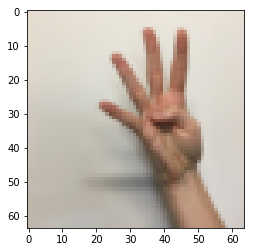

Digit in the image is 4
[[ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]]


In [3]:
X_train = np.load('ex5_train_x.npy')
y_train = np.load('ex5_train_y.npy')
indx = 2
plt.imshow(X_train[indx])
plt.show()
print("Digit in the image is " + str(y_train[indx]))
# print(X_train)

# Normalize the data
X_train_norm = X_train/255 - 0.5
# print(X_train_norm)
y_train_encoded = one_hot_encode(y_train)
# X_train_padded = zero_pad(X_train, 2)

### Q.3 (10pts) Initialize parameters (Weights, bias for each layer)

In [4]:
def initialize_parameters(input_channl, conv1_f, channl_1, conv2_f, channl_2, 
                          input_size, fc1_size, fc2_size):
    params = {}
    # Convolution Layer 1 Params
    params["W1c"] =  np.random.randn(conv1_f, conv1_f, input_channl, channl_1)
    params["b1c"] =  np.zeros((1,1,1, channl_1))
    
    # Convolution Layer 2 Params
    params["W2c"] =  np.random.randn(conv2_f, conv2_f, channl_1, channl_2)
    params["b2c"] =  np.zeros((1,1,1,channl_2))
    
    # FC layer 4 params
    params["W4"] =  np.random.randn(fc1_size, input_size)
    params["b4"] =  np.zeros((fc1_size, 1))
    
    # FC layer 5 params
    params["W5"] =  np.random.randn(fc2_size, fc1_size)
    params["b5"] =  np.zeros((fc2_size, 1))
    
    return params

### Initialize Hyper Parameters

In [5]:
def initialize_hyper_params():
    
    hyper_params = {}
    
    # Convolution Layer 1 Hyper Parameters
    hyper_params_c1 = {}
    hyper_params_c1["stride"] = 2
    hyper_params_c1["pad"] = 1
    
    # Pooling Layer 1 Hyper Parameters
    hyper_params_p1 = {}
    hyper_params_p1["stride"] = 1
    hyper_params_p1["pad"] = 0
    hyper_params_p1["f"] = 5
    
    # Convolution Layer 2 Hyper Parameters
    hyper_params_c2 = {}
    hyper_params_c2["stride"] = 2
    hyper_params_c2["pad"] = 0
    
    # Pooling Layer 2 Hyper Parameters
    hyper_params_p2 = {}
    hyper_params_p2["stride"] = 1
    hyper_params_p2["pad"] = 0
    hyper_params_p2["f"] = 5
    
    hyper_params["c1"] = hyper_params_c1
    hyper_params["p1"] = hyper_params_p1
    
    hyper_params["c2"] = hyper_params_c2
    hyper_params["p2"] = hyper_params_p2
    
    return hyper_params
    

In [6]:
cache = {}
cache["A0"] = X_train_norm
params = initialize_parameters(input_channl=3, conv1_f=4, channl_1=8, conv2_f=4, channl_2=16, 
                          input_size=1296, fc1_size=108, fc2_size=6)
hyper_params = initialize_hyper_params()
cache = forward_propagate(cache, hyper_params, params)


convolution nH_prev, f, pad, stride---------------
64 4 1 2
convolution m, nH, nW, nC---------------
1020 32 32 8
Dimension after padding(1020, 66, 66, 3)
Pooling (m, nH_prev, nW_prev, nC_prev---------------
1020 32 32 8
Pooling f, stride
5 1
convolution nH_prev, f, pad, stride---------------
28 4 0 2
convolution m, nH, nW, nC---------------
1020 13 13 16
Dimension after padding(1020, 28, 28, 8)
Pooling (m, nH_prev, nW_prev, nC_prev---------------
1020 13 13 16
Pooling f, stride
5 1
Shape before flattening is----
(1020, 9, 9, 16)
Shape after flattening is----
(1020, 1296)
Before sigmoid---
[[ 17796.52907485  16495.51505015  14516.22359186 ...,  16305.06080427
   16119.15615225  18847.37054686]
 [  2179.038839     2391.60631008   3246.51567801 ...,   3109.78190771
    2952.4355778    1659.983982  ]
 [  -786.77147639   -737.1381775    -487.35145498 ...,   -293.42698422
    -382.7701899   -1146.89743726]
 [  -168.33529833   -418.64866213    402.06720403 ...,     93.70100858
    -545.60128

/Users/meenakshiparyani/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


In [11]:
for key, value in cache.items():
    print("key " + str(key))
gradients = backward_propagate(y_train_encoded, cache, hyper_params, params)
for key, value in gradients.items():
    print(key)

key A0
key Z1c
key A1c
key A1p
key Z2c
key A2c
key A2p
key A3
key Z4
key A4
key Z5
key A5
shape
(1020, 13, 13, 16)
(1020, 13, 13, 16)
Dimension after padding(1020, 28, 28, 8)
Dimension after padding(1020, 28, 28, 8)
Dimension after padding(1020, 66, 66, 3)
Dimension after padding(1020, 66, 66, 3)
dW5
db5
dW4
db4
dW2
db2
dW1
db1


In [ ]:
# from __future__ import division
# import decimal
# m,n = cache["Z5"].shape
# for i in range(m):
#     for j in range(n):
#         z = cache["Z5"][i][j]
#         if(z>=0):
#             z = np.exp(-z)
#             cache["Z5"][i][j] = 1./(1. + z)
#         else:
#             z = np.exp(z)
#             cache["Z5"][i][j] = z/(1. + z)
            
# print( cache["Z5"])
# print( cache["A5"])
# y_train_encoded = one_hot_encode(y_train)
# # print(y_train_encoded)
# # # print(y_train_encoded.shape)
# # # print(cache["A5"].transpose())
# cost = cross_entropy(cache["A5"].transpose(),y_train_encoded)
# print(cost)

# # # print(cache["Z5"])
# # print()
# # answer = 1.0/(1.0+np.exp(-cache["Z4"]))
# # print(answer)